# Homework 6 solutions

## 1. Polytropes

We want to show that for a polytrope, that the central pressure and central density are related via:

$$P_c = (4\pi)^{1/3} B_n G M_\star^{2/3} \rho_c^{4/3}$$

where $B_n$ is a slowing varying quantity that depends on the polyropic index.

We know from class how the mass of the star relates to the central density:

$$M_\star = -\frac{1}{\sqrt{4\pi}} \left ( \frac{n+1}{G} \right )^{3/2} K^{3/2} \rho_c^{(3-n)/2n} \xi_1^2 \left ( \frac{d\theta}{d\xi} \right )_{\xi_1}$$

We'll define

$$M_n \equiv -\xi_1^2 \left ( \frac{d\theta}{d\xi} \right )_{\xi_1}$$

then we can solve for $K$ as:

$$K = (4\pi)^{1/2} \frac{G}{n+1} \left ( \frac{M_\star}{M_n} \right )^{2/3} \rho_c^{-(3-n)/3n}$$

Our equation of state is 

$$P_c = K \rho_c^{1+1/n}$$

so substituting in this $K$, we have:

$$P_c = (4\pi)^{1/3} \frac{G}{n+1} \left ( \frac{M_\star}{M_n} \right )^{2/3} \rho_c^{4/3}$$

comparing with the original expression, we see that

$$B_n = \frac{1}{n+1} M_\star^{-2/3} = \frac{1}{n+1} \left ( -\xi_1^2 d\theta/d_\xi |_{\xi_1} \right )^{-2/3}$$

We can evaluate this constant using the polytrope solution we wrote earlier:
    
https://zingale.github.io/stars/notebooks/polytrope/lane-emden.html

To make it easier, this is in a module `polytrope.py`

In [1]:
import polytrope

print(f"{'n':3} : {'B_n'}")
for n in [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]:
    p = polytrope.Polytrope(n)
    xi1, M_n = p.get_params()
    
    print(f"{n:3} : {M_n**(-2./3.)/(n+1)}")

n   : B_n
0.5 : 0.27431794080469313
  1 : 0.23309703851599312
1.5 : 0.20558000937178286
  2 : 0.18538520846055065
2.5 : 0.16956635384130325
  3 : 0.1565400194136854
3.5 : 0.14534305619431906
  4 : 0.13529889090495795
4.5 : 0.12578754389114616


as stated in the problem, we see that $B_n$ varies very slowly with $n$.

## 2. MESA solar model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr

We want to compare a $1~M_\odot$ main sequence star's convective zone to the structure we computed 
in an earlier homework.  We'll use the model we explored in class.

In [3]:
m1 = mr.MesaData("M1_default_profile8.data")

Let's see where we are convective by plotting:

$$\nabla - \nabla_\mathrm{ad}$$

and finding the first zone (from the center) where it gets close to 0 (we'll use a tolerance of $10^{-3}$.  Note that
in a MESA model, the outer part of the star comes first and the center last.

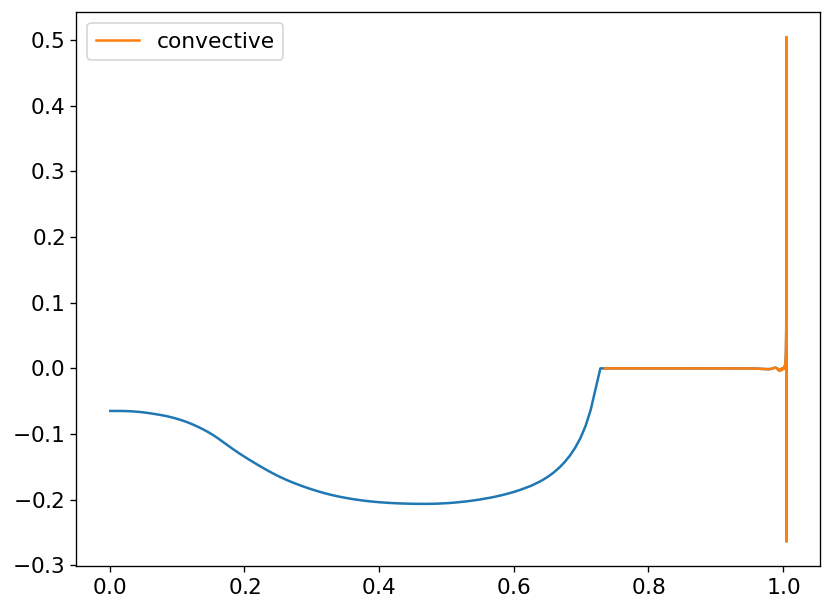

In [4]:
fig, ax = plt.subplots()
ax.plot(m1.radius, m1.gradT - m1.grada)

idx = np.where(np.abs(m1.gradT - m1.grada) <= 1.e-3)[0][-1]
idx
ax.plot(m1.radius[:idx], m1.gradT[:idx] - m1.grada[:idx], label="convective")
ax.legend()

We can see the radius where we are convective:

In [5]:
m1.radius[idx]

0.7286210626316078

and we can get the temperature there and put the radius in CGS

In [6]:
T_base = 10.0**m1.logT[idx]
R_base = m1.radius[idx] * 7e10

T_base, R_base

(2152662.4071955117, 51003474384.21254)

In our homework, we assumed a uniform composition and negligible mass in the convective layer and computed the temperature structure:

$$T(r) = T_\mathrm{base} - \left ( 1 - \frac{1}{\gamma} \right ) \frac{\mu m_u GM_\odot}{k} \left (\frac{1}{R_\mathrm{base}} - \frac{1}{r}\right )$$

Let's plot that and the MESA model

First some constants (CGS)

In [7]:
m_u = 1.66e-24
G = 6.68e-8
k = 1.38e-16
M_sun = 2.e33
R_sun = 7.e10

In [8]:
def T(r):
    gamma = 5./3.
    mu = 0.6
    return T_base - (1.0 - 1.0 / gamma) * mu * m_u * G * M_sun / k * (1/R_base - 1/(r * R_sun))

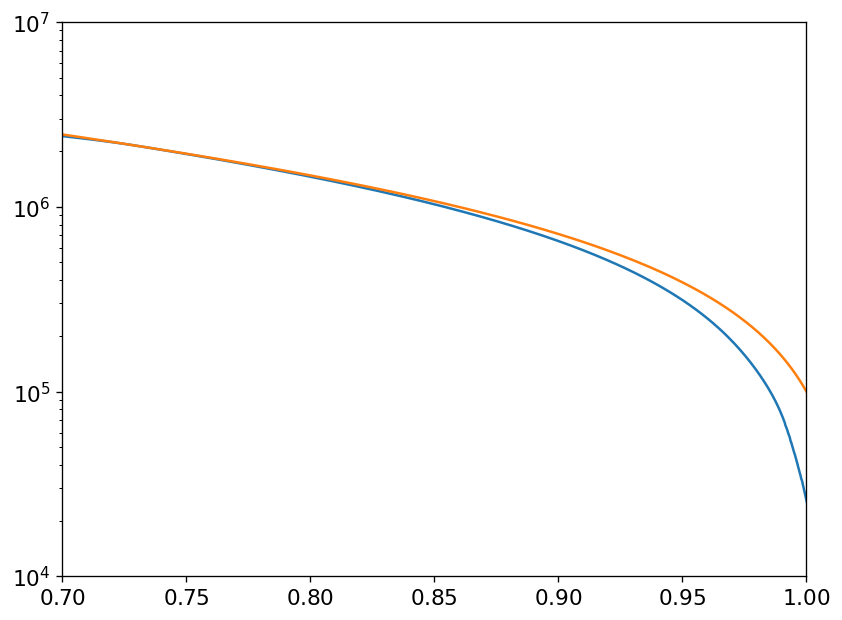

In [9]:
fig, ax = plt.subplots()
ax.plot(m1.radius, 10.0**m1.logT)
ax.plot(m1.radius, T(m1.radius))
ax.set_xlim(0.7, 1.0)
ax.set_ylim(1.e4, 1.e7)
ax.set_yscale("log")

We see good agreement between the two until we get near the surface of the Sun

## 3. Eddington standard model

In class, we derived the Eddington standard model by assuming that the star was completely radiative, had a fixed ratio of gas to total pressure, and a uniform composition.  This gave us:

$$T(r) = 4.62\times 10^6 \beta\mu \left ( \frac{M}{M_\odot} \right)^{2/3} \rho^{1/3}(r)$$

We'll compare this to the $15~M_\odot$ stellar model we looked at in class.

In [10]:
m15 = mr.MesaData("M15_aprox21_profile8.data")

Let's compute $\beta$.  We'll do this using the center of the stellar model

In [11]:
beta = m15.pgas[-1] / m15.pressure[-1]
beta

0.8717590356628069

In [12]:
mu = m15.mu[-1]
mu

0.6846986642505136

In [13]:
M = m15.star_mass
M

14.999963185702338

Here's a function to compute the $T(\rho)$ curve

In [14]:
def eddington_T(rho, beta, mu, M):
    return 4.62e6 * beta * mu * M**(2./3.) * rho**(1./3.)

Text(0.5, 1.0, 'M = 15.000 $M_\\odot$; age = 2.44091e+06 years')

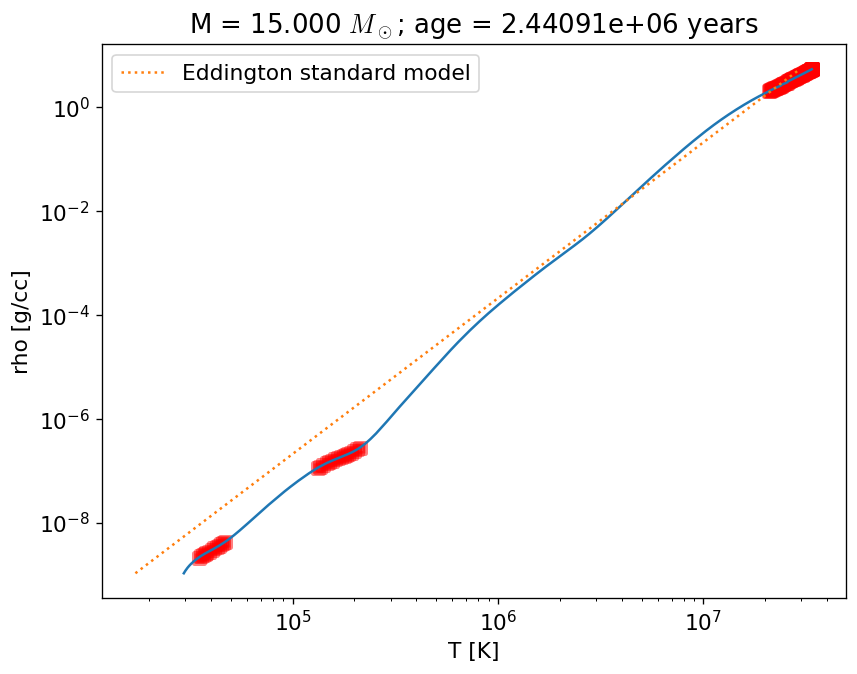

In [15]:
T = 10.0**m15.logT
rho = 10.0**m15.logRho

fig, ax = plt.subplots()
ax.loglog(T, rho)
    
# find where it is convective
idx = m15.gradT >= m15.grada
ax.scatter(T[idx], rho[idx],
           color="r", marker="s", alpha=0.5, linewidth=3)
ax.loglog(eddington_T(rho, beta, mu, M), rho,
          ls=":", label="Eddington standard model")
ax.legend()
ax.set_xlabel("T [K]")
ax.set_ylabel("rho [g/cc]")
ax.set_title(rf"M = {M:6.3f} $M_\odot$; age = {m15.star_age:10.6g} years")

Here the red points mark where the star is convective.  We see that the Eddington model marks the trend reasonably well near the center but does not do a good job at the surface.